In [203]:
import petl as etl
import pandas as pd
import seaborn as sns

In [204]:
sns.set_theme()

In [205]:
census = etl.fromdataframe(pd.read_parquet('data/census.parquet'))

In [206]:
categories = etl.lookup(
    etl.fromcsv('data/census_categories.csv'),
    key='variable',
    value='category'
)

In [207]:
def by_ward(variable):
    return (
        census
        .selecteq('variable', variable)
        .selecteq('measure', 'Percent')
        .select(lambda r: r.geography_code.startswith('E05'))
        .recast(
            variablefield='category',
            valuefield='value'
        )
        .cut(
            'geography_name',
            *categories.get(variable)
        )
    )

In [208]:
chart_config = {
    'kind': 'barh',
    'stacked': True,
    'figsize': (12, 12),
    'xlim': (0, 100),
    'width': 1,
    'ylabel': 'Ward',
}

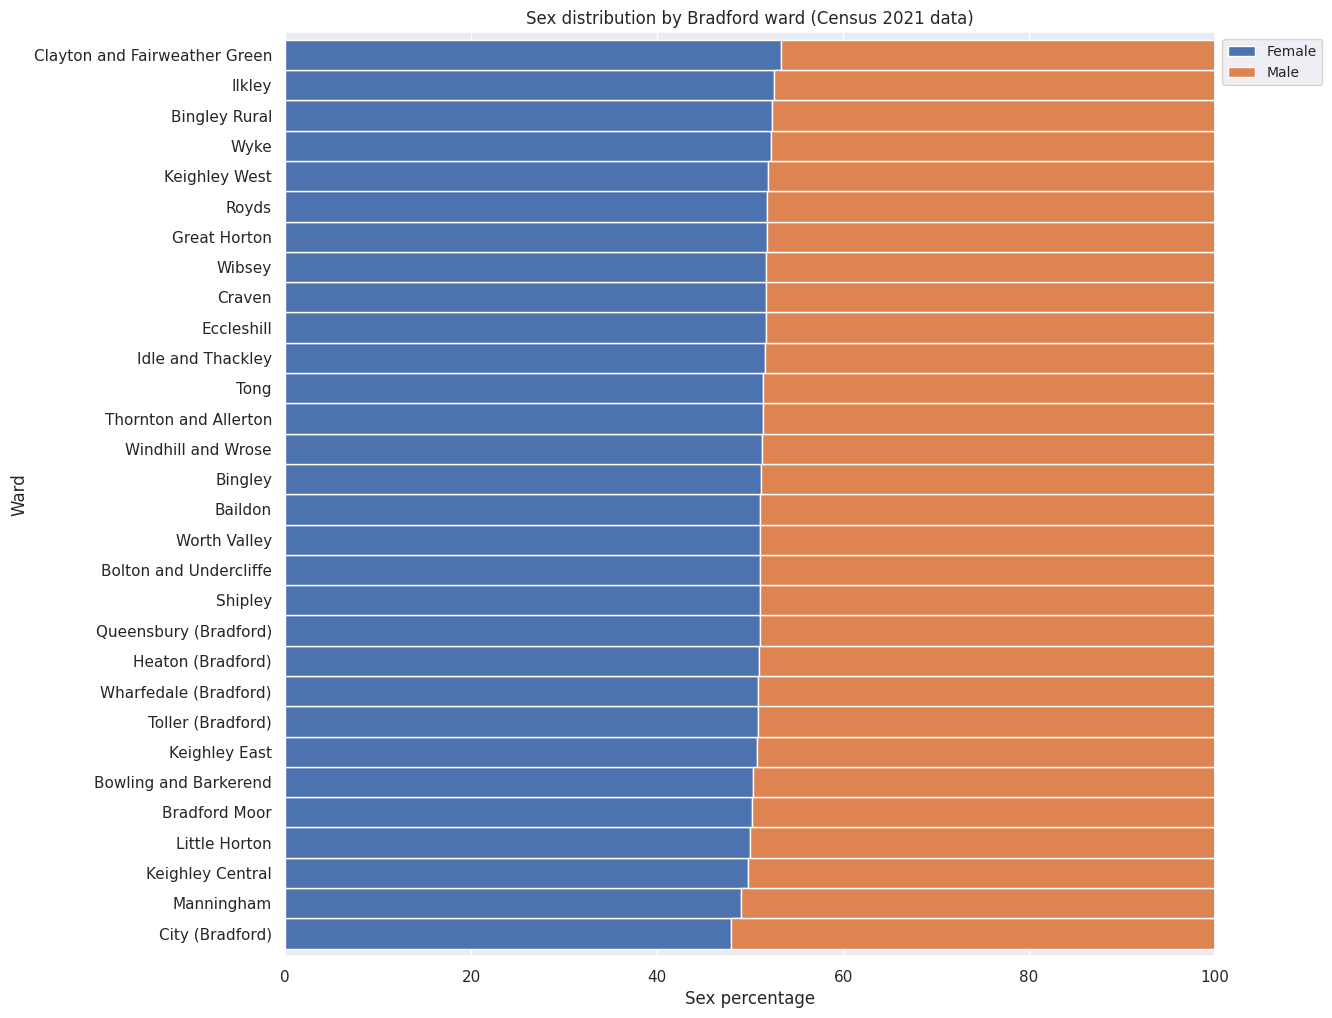

In [209]:
(
    by_ward('Sex')
    .todataframe()
    .set_index('geography_name')
    .sort_values('Female')
    .plot(**chart_config, title="Sex distribution by Bradford ward (Census 2021 data)", xlabel="Sex percentage")
    .legend(bbox_to_anchor=(1.0, 1.0), fontsize='small')
)

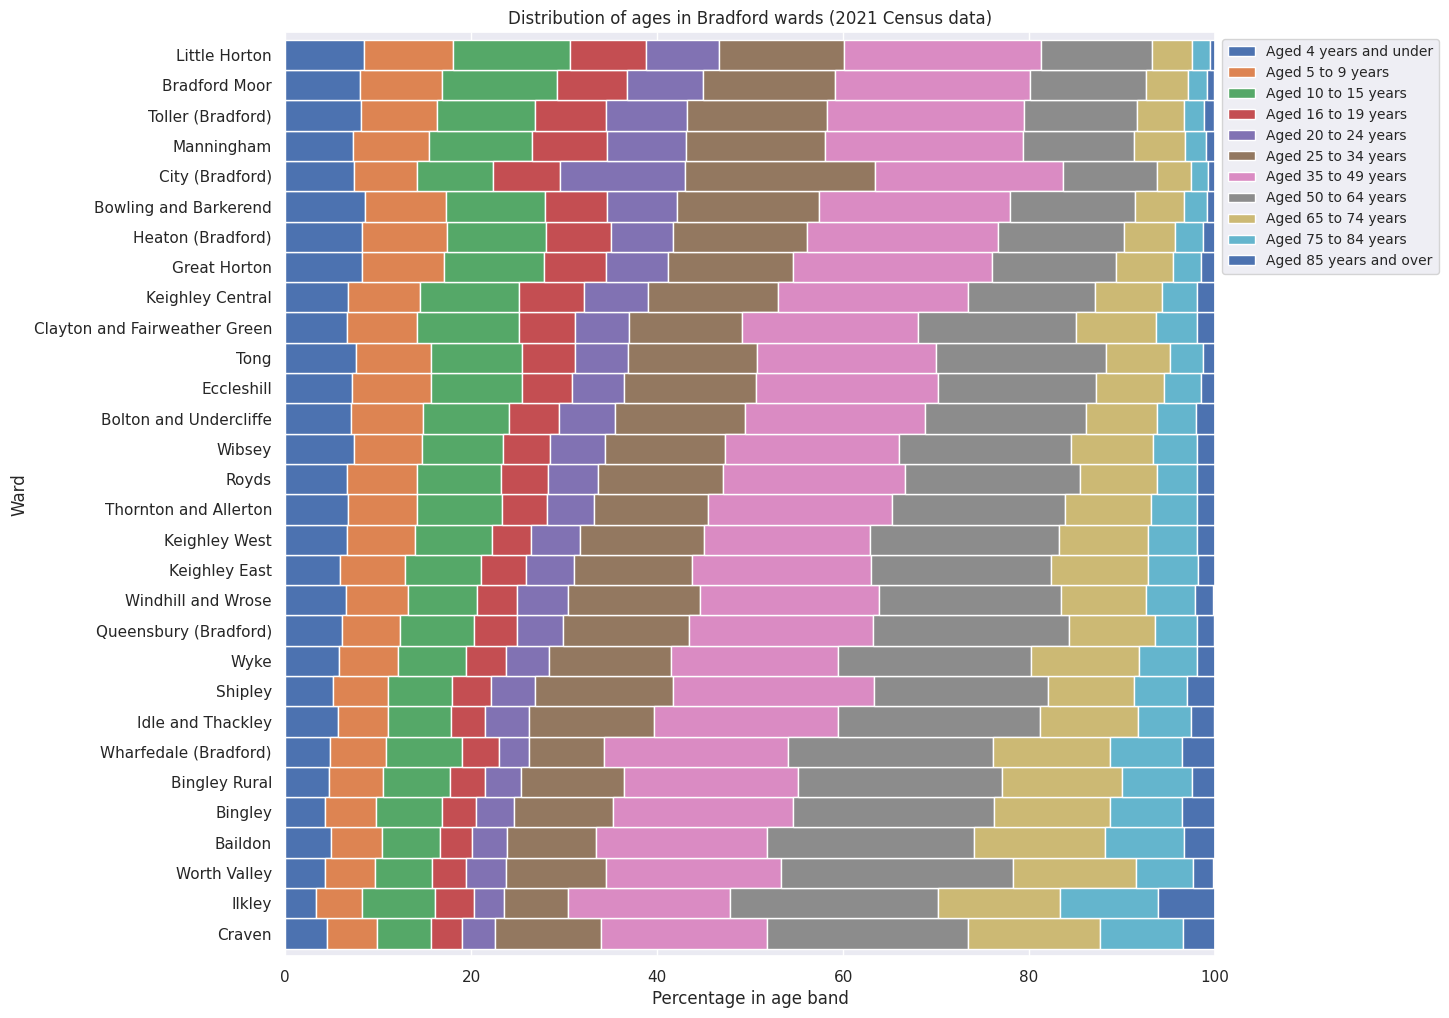

In [210]:
def custom_sort(df):
    order = (
        # Get first 5 age categories (up to age 24)
        df[categories.get('Age')[0:5]]
        # Create total
        .sum(axis=1)
        # Sort ascending
        .sort_values(ascending=True)
        # Return the index
        .index
    )
    # Return the data frame sorted per the subset
    return df.loc[order]

plot = (
    by_ward('Age').todataframe()
    .pipe(custom_sort)
    .set_index('geography_name')
    .plot(
        **chart_config,
        title='Distribution of ages in Bradford wards (2021 Census data)',
        xlabel='Percentage in age band'
    )
)
legend = plot.legend(
    bbox_to_anchor=(1.0, 1.0),
    fontsize='small'
)

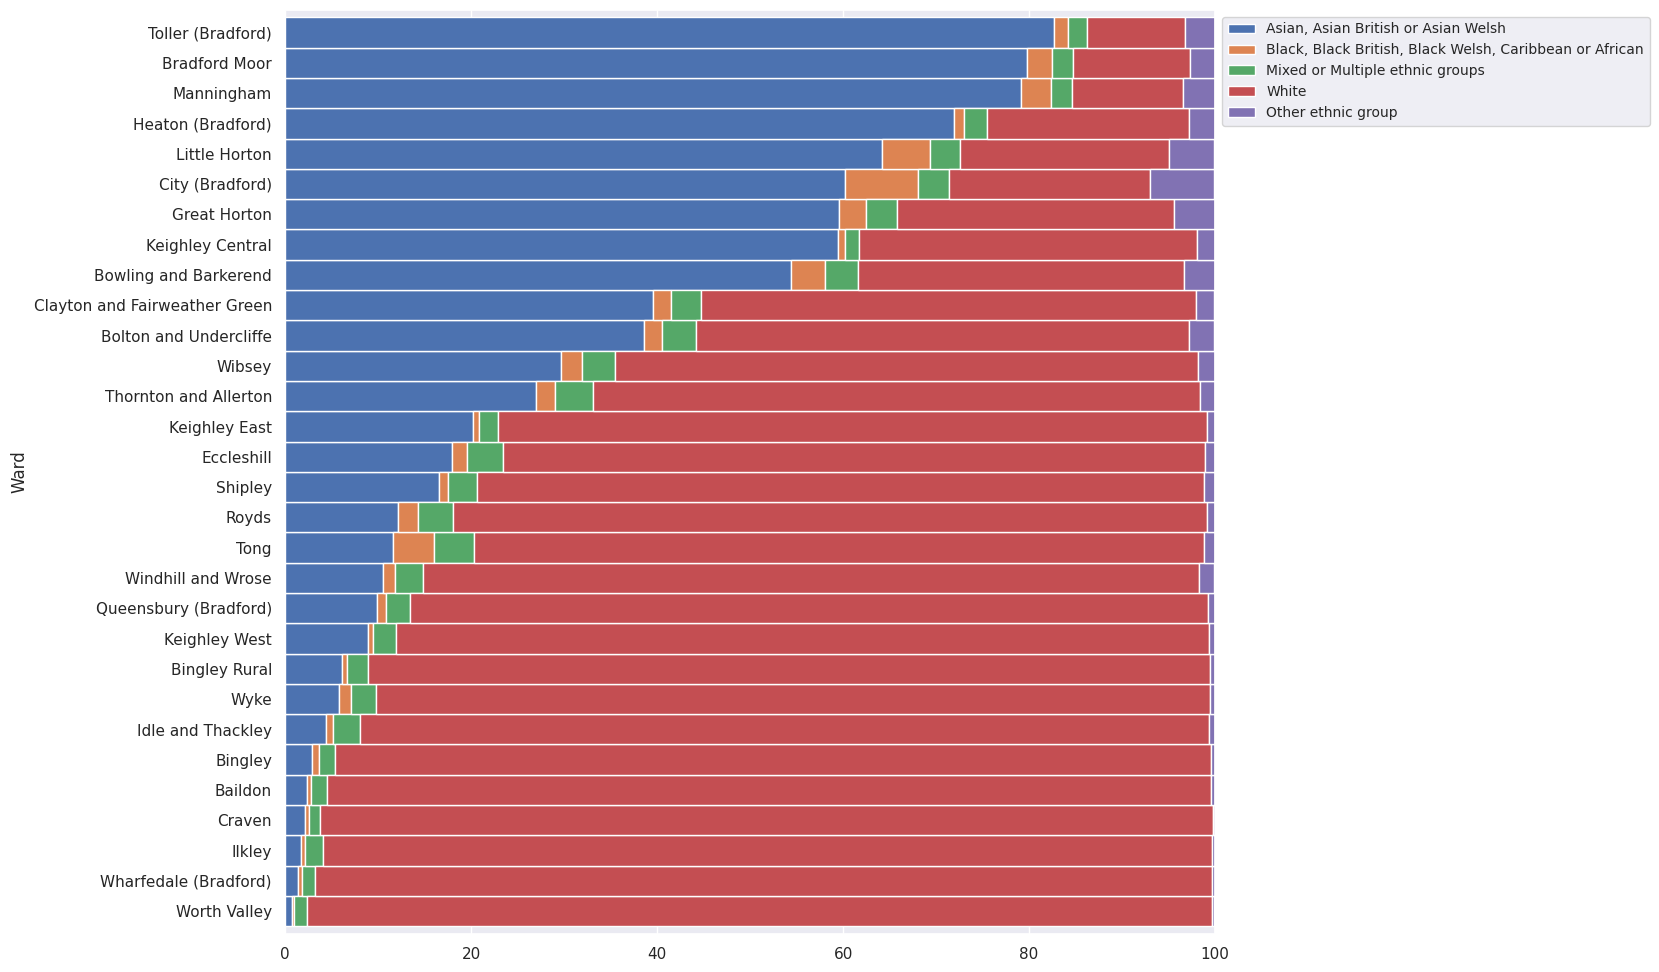

In [217]:
by_ward('Ethnic group').todataframe().set_index('geography_name').sort_values('Asian, Asian British or Asian Welsh').plot(**chart_config).legend(
    bbox_to_anchor=(1.0, 1.0),
    fontsize='small'
)